# Building Models with PyMC and MCMC Fundamentals

In the previous session, we explored the foundations of Bayesian inference, including Bayes' theorem, conjugate priors, and the mechanics of Bayesian updating for simple models. 

This session introduces PyMC, a powerful probabilistic programming framework that enables us to build and analyze complex Bayesian models. We'll learn how to specify models using PyMC's intuitive API, understand the theoretical foundations of Markov Chain Monte Carlo (MCMC) methods that make modern Bayesian computation possible, and work through practical examples that demonstrate the complete modeling workflow.

## Learning Objectives

By the end of this session, you will be able to:

1. **Build probabilistic models in PyMC**: Understand PyMC's core components including distributions, random variables, and the model context
2. **Specify model structure**: Learn how to encode assumptions about data generating processes using priors and likelihoods
3. **Understand MCMC fundamentals**: Grasp why we need MCMC, how it works conceptually, and what makes it powerful for Bayesian inference
4. **Implement complete Bayesian analyses**: Build, fit, and interpret results from real-world models including linear regression

## Why PyMC?

PyMC provides several key advantages for Bayesian modeling:

- **Expressive model specification**: Write models that look like their mathematical notation
- **Automatic differentiation**: No need to derive gradients by hand
- **State-of-the-art samplers**: Access to efficient MCMC algorithms like NUTS (No-U-Turn Sampler)
- **Comprehensive diagnostics**: Built-in tools for assessing convergence and model quality
- **Integration with the PyData ecosystem**: Works seamlessly with NumPy, Pandas, and visualization libraries

Let's begin by setting up our environment and exploring PyMC's fundamental concepts.

In [ ]:
import itertools
import numpy as np
import pymc as pm
import arviz as az
import polars as pl
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import matplotlib.pyplot as plt
import scipy.stats as st

# Visual style
az.style.use('arviz-doc')
pio.templates.default = 'plotly_white'

# Plotly defaults
px.defaults.template = 'plotly_white'
px.defaults.width = 900
px.defaults.height = 500
_base = pio.templates['plotly_white']
_tmpl = go.layout.Template(_base)
_tmpl.layout.hovermode = 'x unified'
pio.templates['hoverx'] = _tmpl
pio.templates.default = 'plotly_white+hoverx'

# Reproducibility
RANDOM_SEED = 20090425
RNG = np.random.default_rng(RANDOM_SEED)

## Part 1: Building Models in PyMC

Probabilistic programming represents a paradigm shift in how we approach statistical modeling. Instead of deriving update equations or coding samplers by hand, we declare the structure of our model and let the framework handle the computational details. PyMC exemplifies this approach by providing an intuitive interface that closely mirrors mathematical notation while leveraging sophisticated algorithms under the hood.

### The Philosophy of Probabilistic Programming

In traditional statistical programming, we often work backwards from the inference algorithm. We might derive the posterior distribution analytically (if we're lucky), implement a specific sampling scheme, or resort to approximations. This approach becomes increasingly difficult as models grow in complexity.

Probabilistic programming flips this workflow. We start by specifying what we know:
- **Prior knowledge** about parameters before seeing data
- **The data generating process** that connects parameters to observations
- **The observed data** itself

From this specification, PyMC automatically constructs the computational graph needed for inference, applies appropriate transformations for constrained parameters, and selects suitable sampling algorithms.

### PyMC's Core Abstractions

PyMC organizes probabilistic models around several key concepts:

1. **The Model Context**: Every PyMC model exists within a context that tracks relationships between variables. This context manager pattern ensures that all model components are properly registered and connected.

2. **Random Variables**: These represent quantities with uncertainty. In Bayesian modeling, parameters are random variables with prior distributions, and data are random variables with likelihood distributions.

3. **Distributions**: PyMC provides a comprehensive library of probability distributions. Each distribution can create random variables when used within a model context.

4. **Deterministic Transformations**: Often we need to transform parameters or compute derived quantities. PyMC tracks these deterministic relationships to maintain the full model structure.

5. **Observed Data**: By marking random variables as observed, we condition the model on actual data, transforming prior distributions into posterior distributions.

Let's explore these concepts through hands-on examples.

### The Distribution Class

At the heart of PyMC lies the `Distribution` class, which encapsulates probability distributions and their properties. Understanding how distributions work in PyMC is crucial for effective model building.

#### Random Variables and Distributions

In probability theory, a random variable is a function that assigns numerical values to outcomes of random phenomena. In PyMC, we create random variables by instantiating distributions within a model context. This seemingly simple act triggers a sophisticated chain of events:

1. **Registration**: The variable is registered with the model's computational graph
2. **Transformation**: If the variable has constrained support (e.g., positive only), PyMC automatically applies bijective transformations to map it to unconstrained space
3. **Tracking**: Dependencies between variables are recorded for efficient computation

#### Key Properties of Distributions

Every PyMC distribution provides several important methods and properties:

- **Random Sampling**: Generate random draws from the distribution
- **Log probability**: Evaluate the log probability density/mass at specific values
- **Moments**: Access theoretical moments like mean and variance
- **Support**: The valid range of values for the distribution

#### Common Arguments

When creating distributions in PyMC, you'll encounter these standard arguments:

- **`name`** (required): A unique string identifier for the variable. This name is used in results, plots, and diagnostics.

- **`shape`**: Specifies the dimensions of the variable. For example, `shape=(3,)` creates three independent draws from the distribution.

- **`dims`**: Named dimensions that provide semantic meaning and integrate with labeled coordinates. This is particularly useful for hierarchical models.

- **`observed`**: Providing data here conditions the distribution, turning it from a prior into a likelihood. This is how we incorporate evidence into our models.

- **`transform`**: While usually handled automatically, you can specify custom transformations for specialized needs.

- **`initval`**: Starting values for sampling algorithms. PyMC usually chooses sensible defaults, but manual specification can help with convergence.

### Working with Distributions

PyMC distributions can be used in two ways:

1. **Inside a model context**: Creates a random variable tracked by the model
2. **Standalone with `.dist()`**: Creates a distribution object for direct use

In [2]:
x_dist = pm.Normal.dist(mu=0, sigma=1)
x_dist

normal_rv{"(),()->()"}.out

In [3]:
samples = pm.draw(x_dist, draws=1000, random_seed=RNG)
px.histogram(samples, title="Samples from Normal(0, 1)").update_layout(
    xaxis_title="Value", yaxis_title="Count", showlegend=False
)

In [4]:
# Calculate log probability
log_prob = pm.logp(x_dist, 0.5).eval()
print(f"Log probability of x=0.5: {log_prob:.4f}")


Log probability of x=0.5: -1.0439


In [5]:
# Inside a model context - creates tracked random variables
with pm.Model() as model:
    # Prior distribution
    mu = pm.Normal('mu', mu=0, sigma=10)
    
    # Another prior
    sigma = pm.HalfNormal('sigma', sigma=5)
    
    # Likelihood (with observed data)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=[1.2, 0.8, 1.5, 0.9])

# The model now contains these variables
print(f"Model variables: {list(model.values_to_rvs.keys())}")

Model variables: [mu, sigma_log__, TensorConstant(TensorType(float64, shape=(4,)), data=array([1.2 ... 1.5, 0.9]))]


## Part 2: Model Specification and Structure

PyMC models are built using Python's context manager idiom. The `Model` context tracks all variables and their relationships, creating a directed acyclic graph (DAG) that represents the probabilistic model.

### Core Components

1. **Stochastic Random Variables**: Variables with uncertainty, defined by probability distributions
   - Unobserved (parameters to estimate)
   - Observed (data)

2. **Deterministic Variables**: Variables computed from other variables with no additional randomness

3. **Factor Potentials**: Terms that modify the joint log-probability

4. **Data Containers**: Special variables for data that is mutable

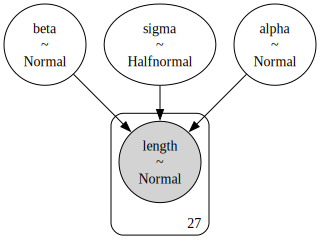

In [6]:
dugongs = (
    pl.read_csv('../data/dugongs.csv')
      .with_columns(pl.col('age').log().alias('log_age'))
)

X = dugongs.get_column('log_age').to_numpy()
y = dugongs.get_column('length').to_numpy()

with pm.Model() as dugong_loglm:
    alpha = pm.Normal('alpha', mu=2.0, sigma=1.0)
    beta = pm.Normal('beta', mu=0.5, sigma=0.5)
    sigma = pm.HalfNormal('sigma', sigma=0.2)

    mu = alpha + beta * X
    pm.Normal('length', mu=mu, sigma=sigma, observed=y)

pm.model_to_graphviz(dugong_loglm)

## Part 3: Likelihood Functions and Prior Distributions

In Bayesian modeling, we combine prior beliefs about parameters with data through a likelihood function. PyMC provides a rich set of distributions for both.

### Common Prior Distributions

**For location parameters (means, intercepts):**
- `Normal(mu, sigma)`: When you expect values around a certain point
- `StudentT(nu, mu, sigma)`: Robust to outliers, heavier tails than Normal
- `Uniform(lower, upper)`: Flat prior over a range (use sparingly)

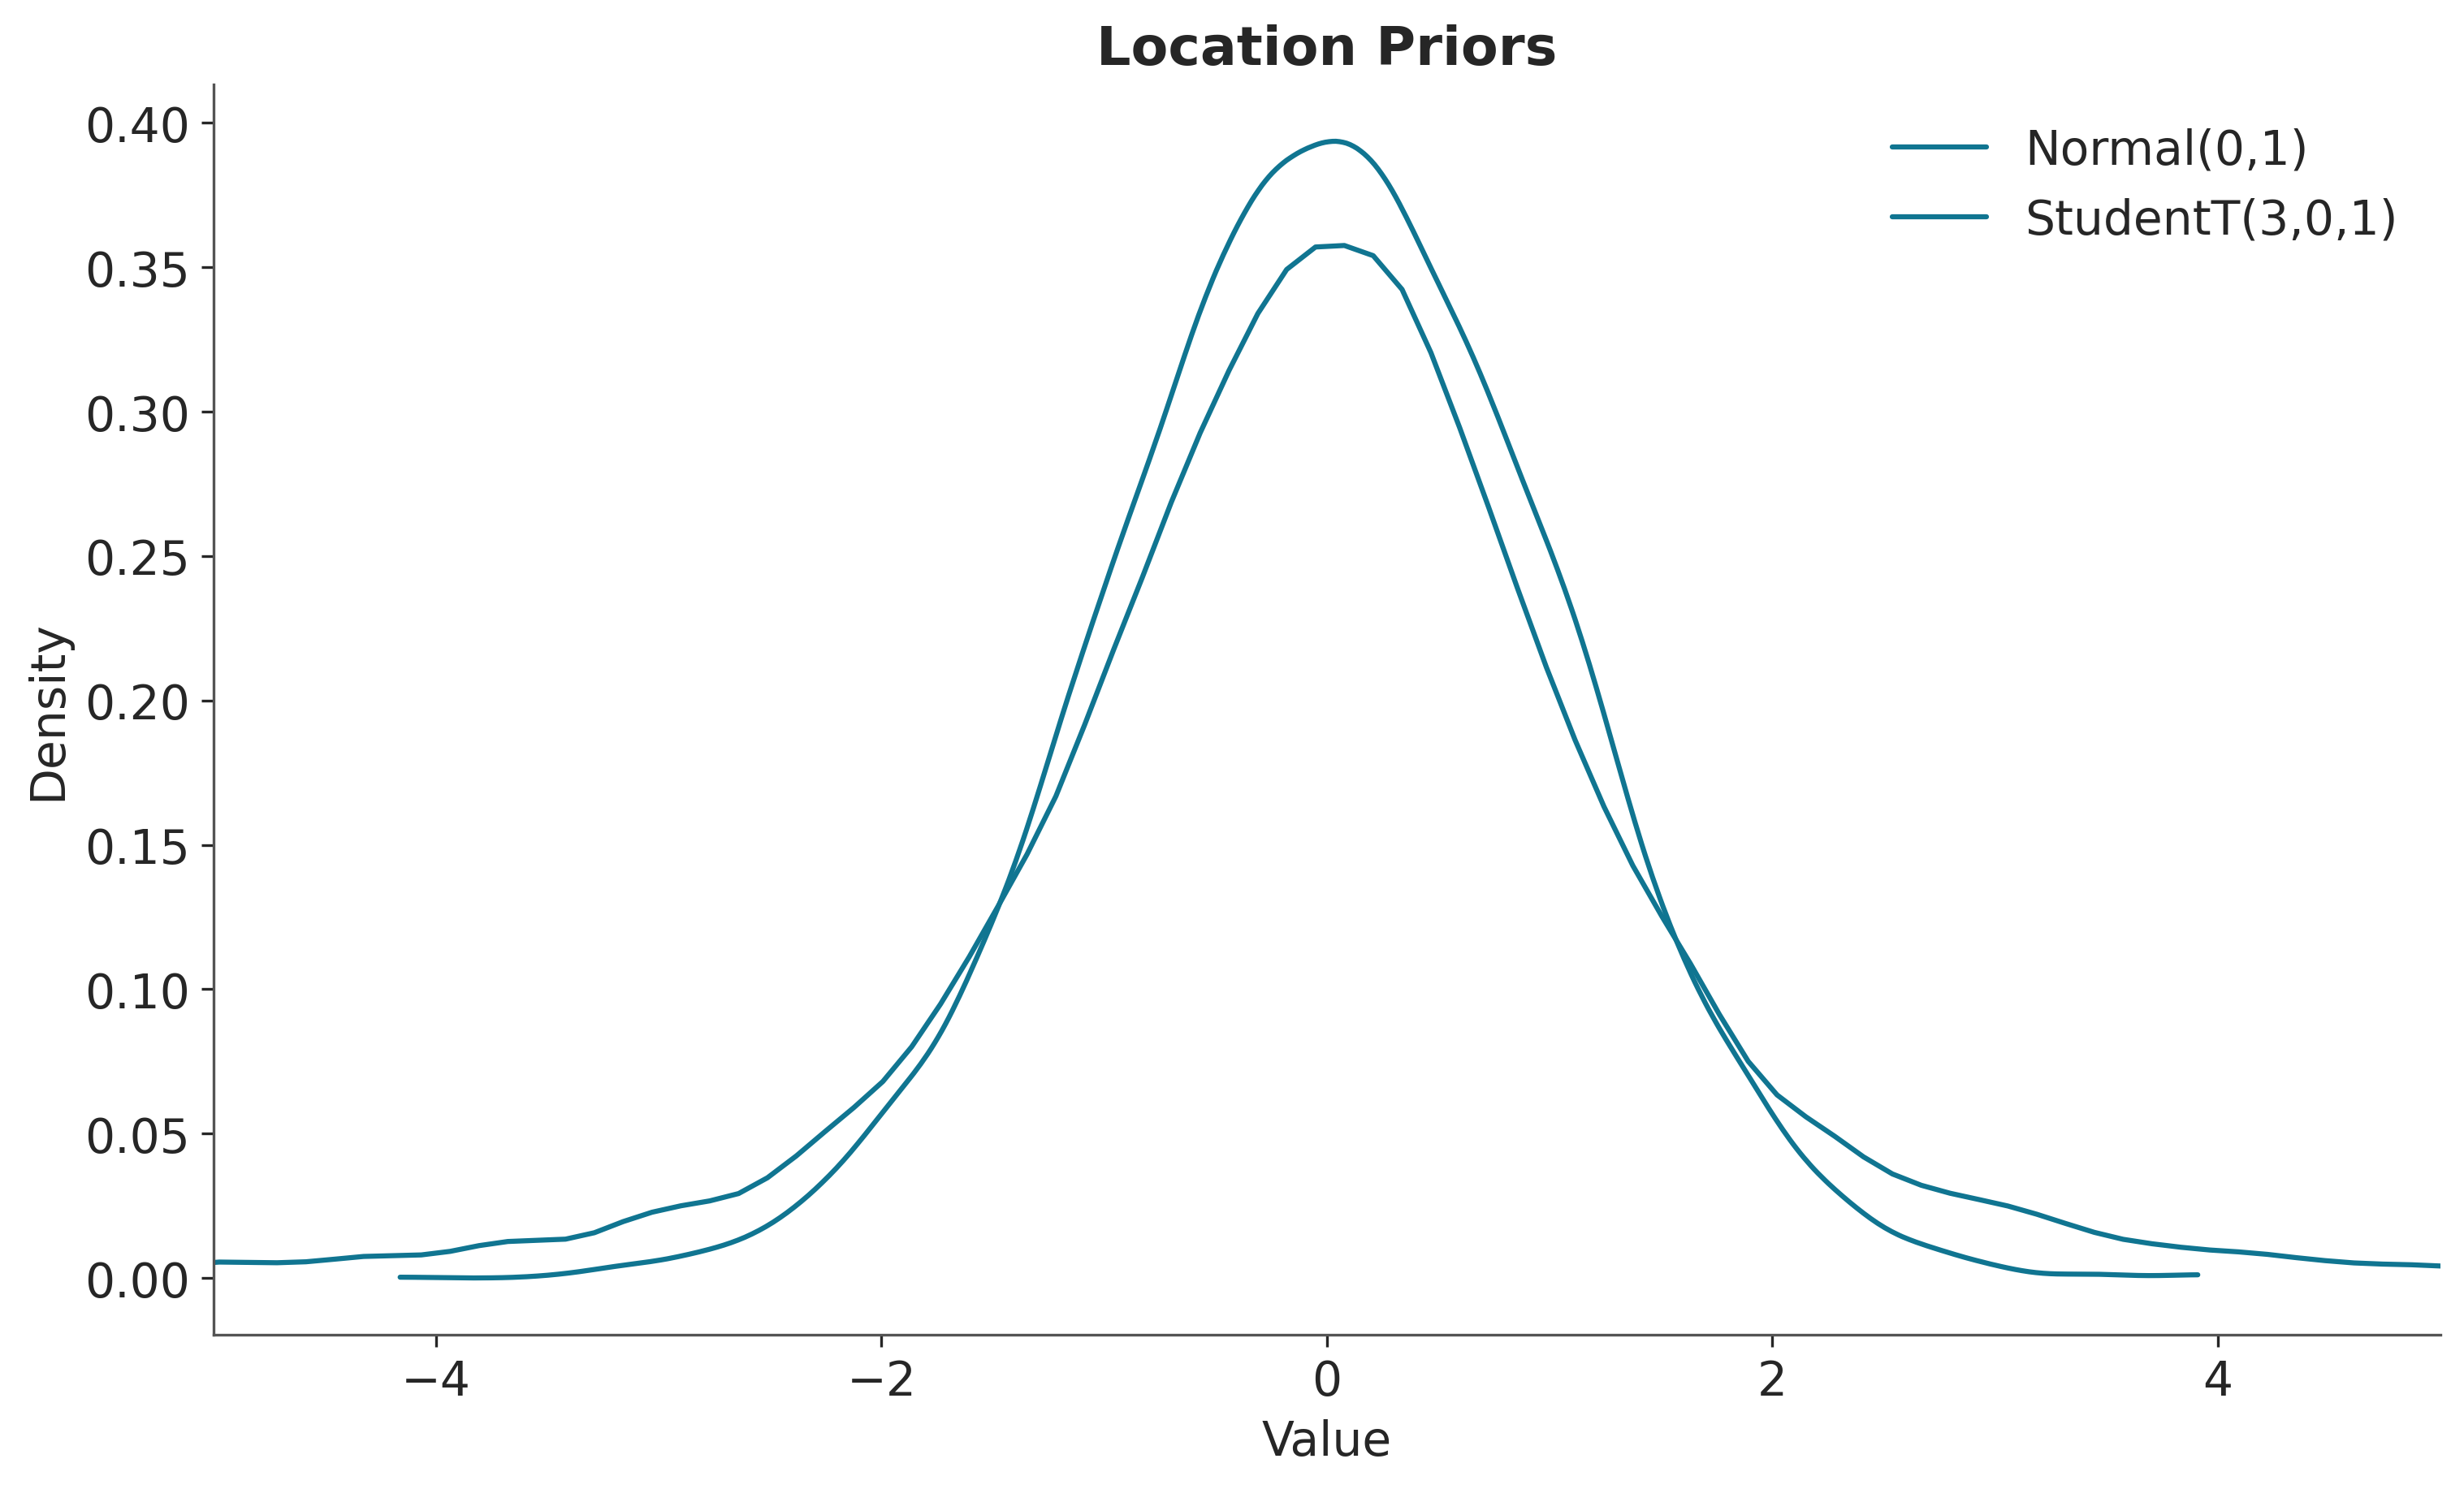

In [25]:
n_draws = 20000
samples_normal = pm.draw(pm.Normal.dist(0, 1), draws=n_draws, random_seed=RNG)
samples_student = pm.draw(pm.StudentT.dist(nu=3, mu=0, sigma=1), draws=n_draws, random_seed=RNG)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
az.plot_kde(samples_normal, ax=ax, label='Normal(0,1)')
az.plot_kde(samples_student, ax=ax, label='StudentT(3,0,1)')
ax.set_title('Location Priors')
ax.set_xlim(-5, 5)
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend();

**For scale parameters (standard deviations, variances):**
- `HalfNormal(sigma)`: Positive values with mode at 0
- `HalfCauchy(beta)`: Heavy-tailed, good for hierarchical models
- `Exponential(lam)`: Alternative for positive parameters
- `InverseGamma(alpha, beta)`: Traditional but less recommended

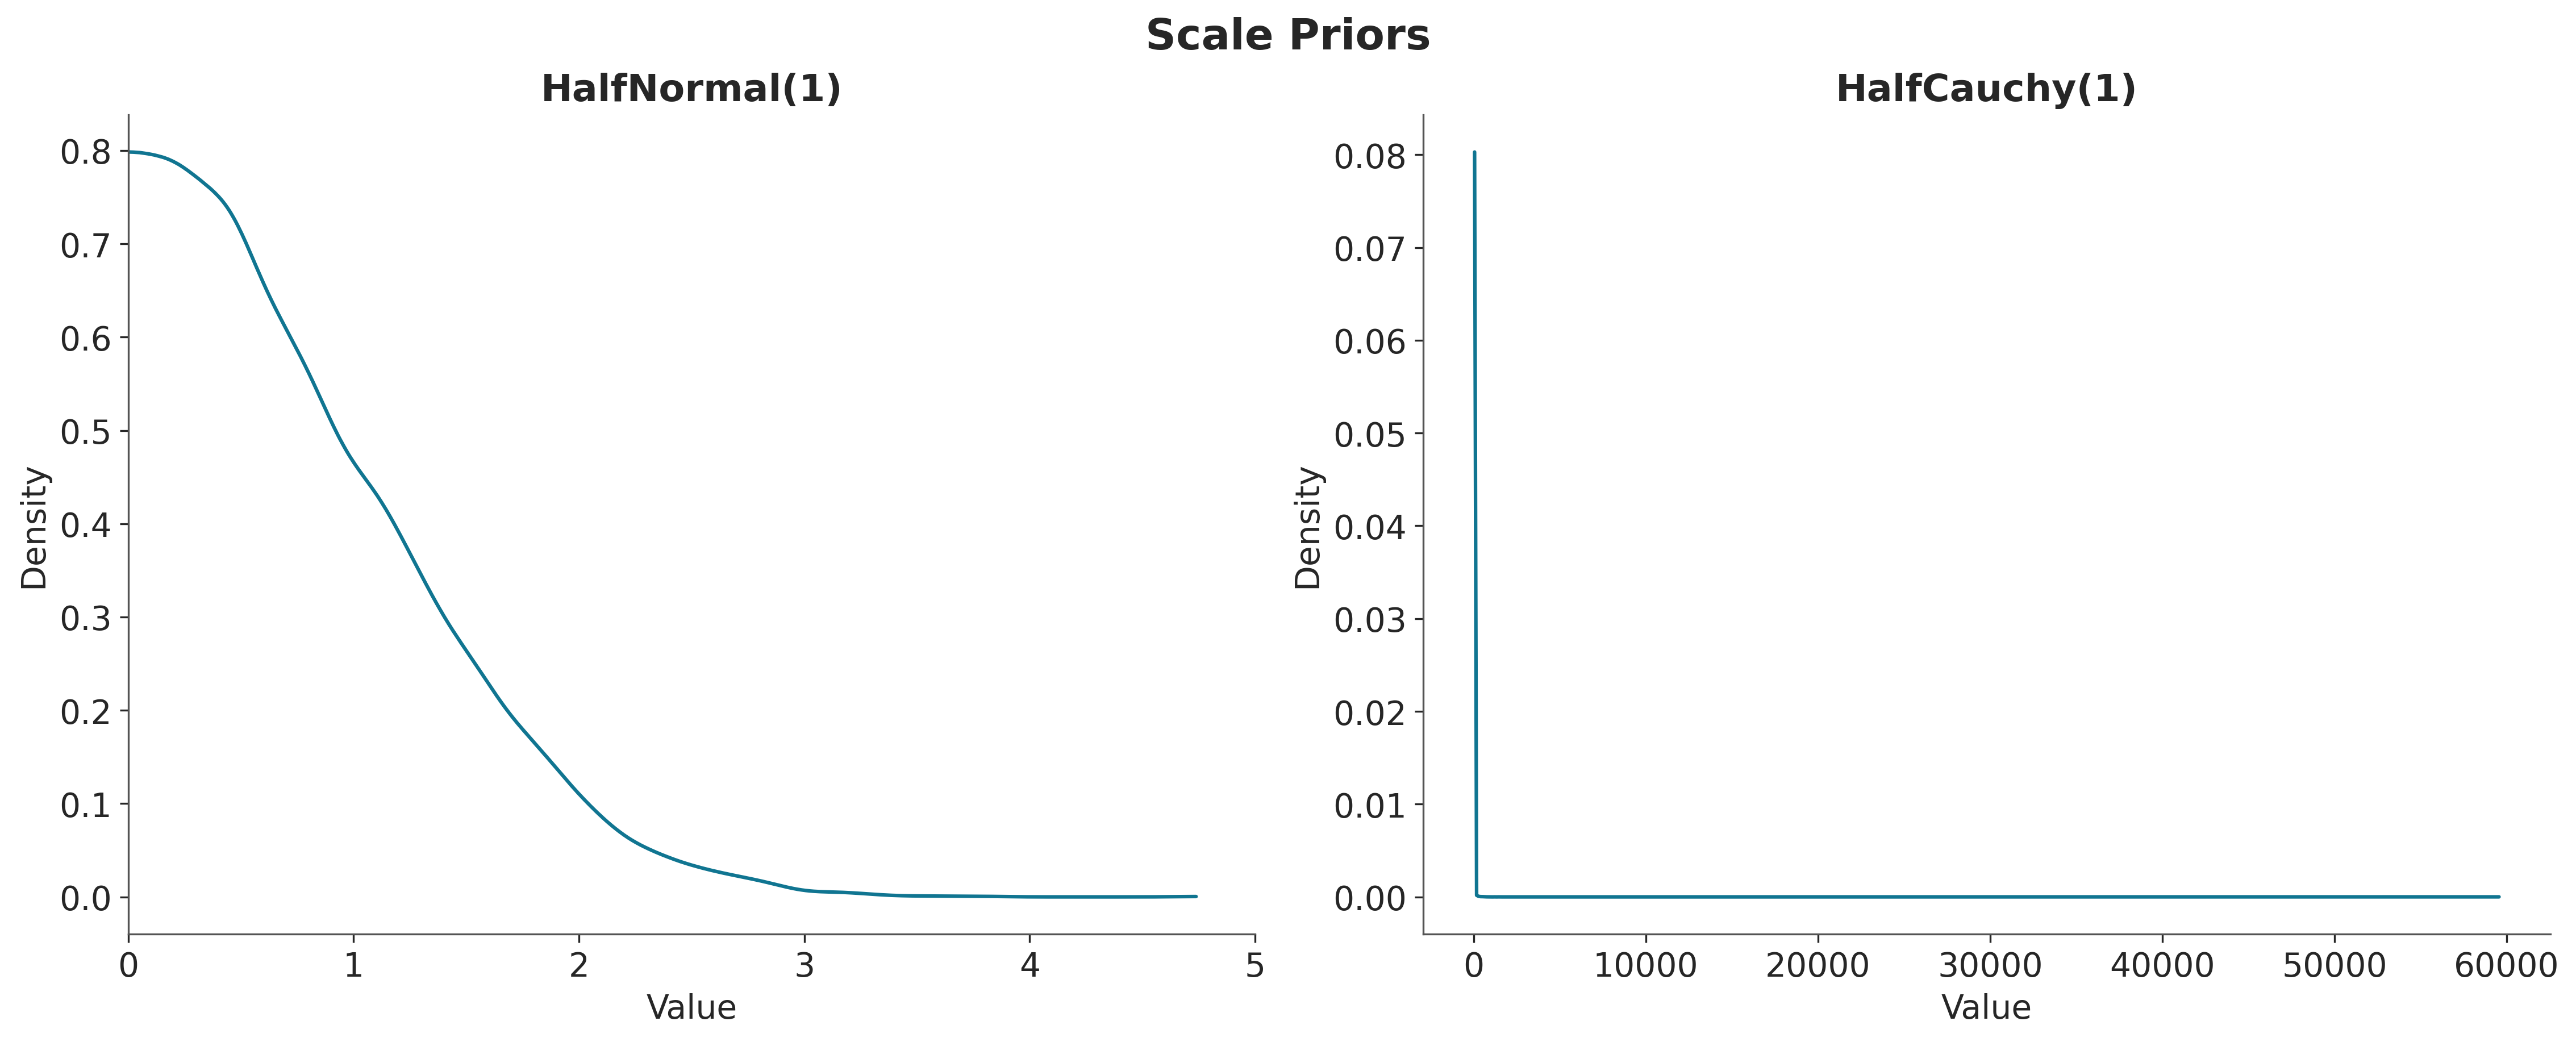

In [33]:
samples_halfnormal = pm.draw(pm.HalfNormal.dist(1), draws=n_draws, random_seed=RNG)
samples_halfcauchy = pm.draw(pm.HalfCauchy.dist(1), draws=n_draws, random_seed=RNG)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
az.plot_kde(samples_halfnormal, ax=axes[0])
axes[0].set_title('HalfNormal(1)')
axes[0].set_xlim(0, 5)
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Density')

az.plot_kde(samples_halfcauchy, ax=axes[1])
axes[1].set_title('HalfCauchy(1)')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Density')

fig.suptitle('Scale Priors');

**For probabilities and proportions:**
- `Beta(alpha, beta)`: Flexible distribution on [0, 1]
- `Dirichlet(a)`: Multivariate generalization of Beta


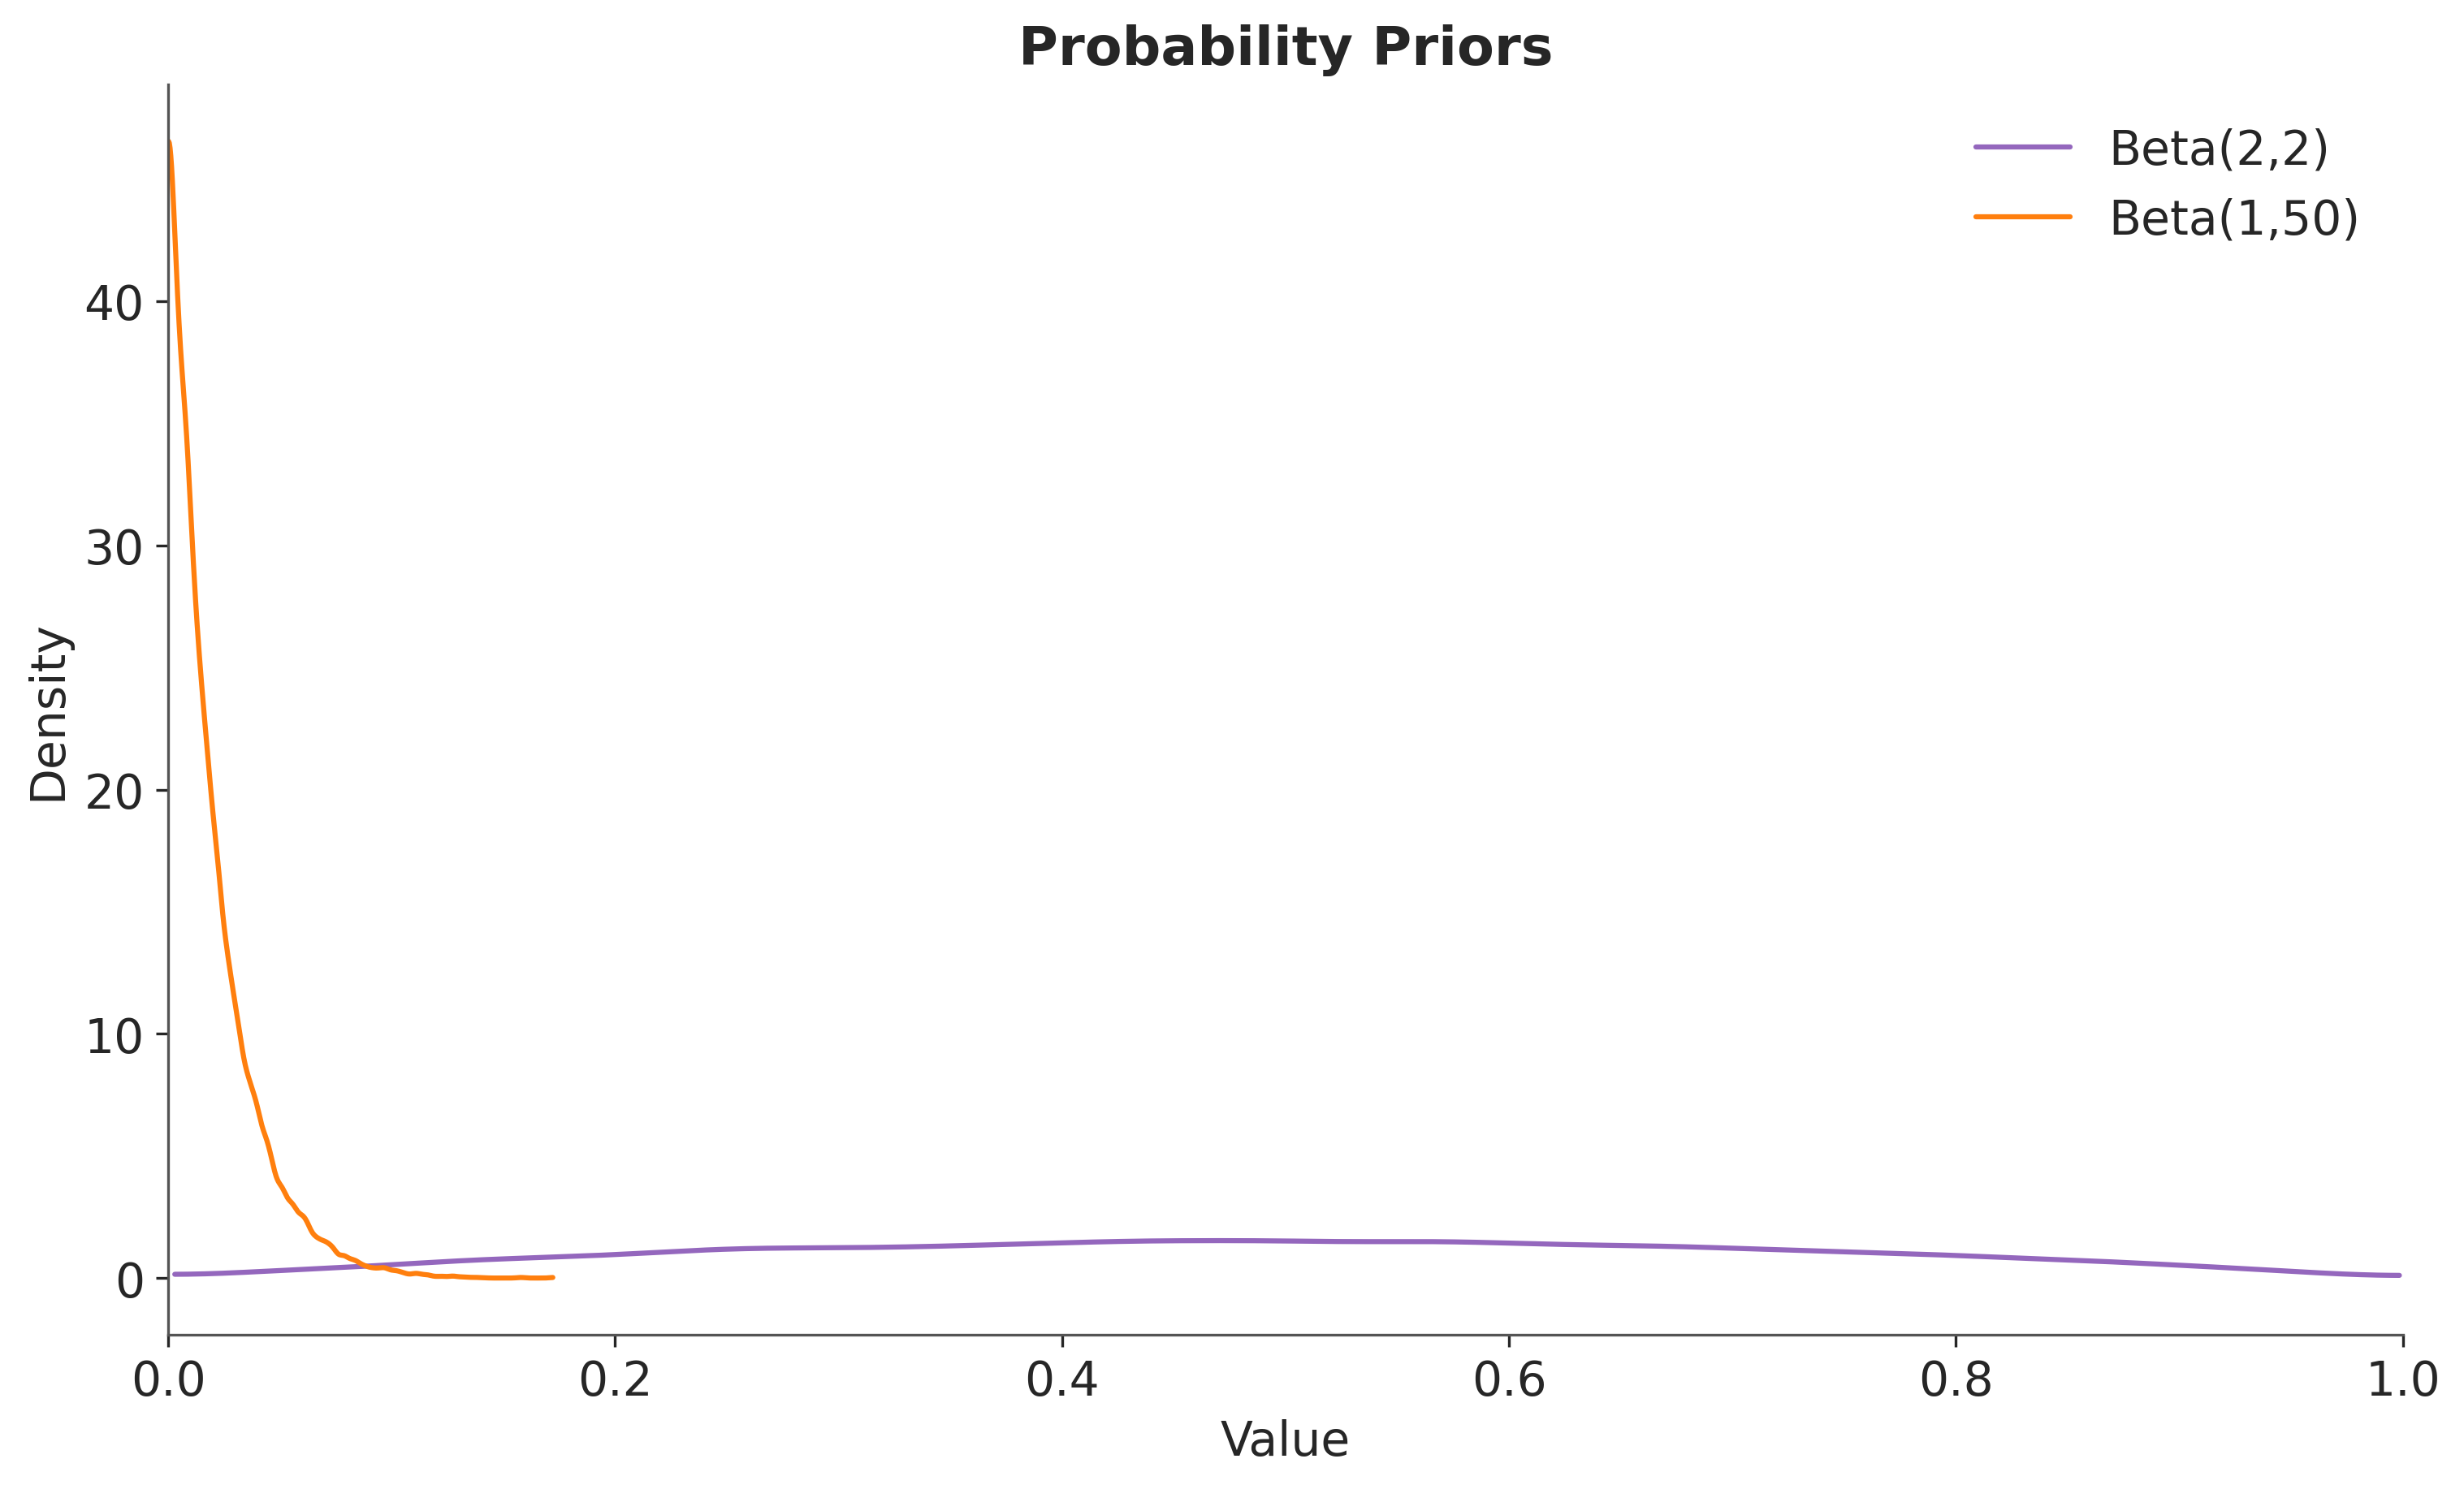

In [42]:
samples_beta22 = pm.draw(pm.Beta.dist(2, 2), draws=n_draws, random_seed=RNG)
samples_beta05 = pm.draw(pm.Beta.dist(1, 50), draws=n_draws, random_seed=RNG)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
az.plot_kde(samples_beta22, ax=ax, label='Beta(2,2)', plot_kwargs={'color': '#9467bd'})
az.plot_kde(samples_beta05, ax=ax, label='Beta(1,50)', plot_kwargs={'color': '#ff7f0e'})
ax.set_title('Probability Priors')
ax.set_xlim(0, 1)
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend();

**For counts:**
- `Poisson(mu)`: Count data with equal mean and variance
- `NegativeBinomial(mu, alpha)`: Overdispersed count data

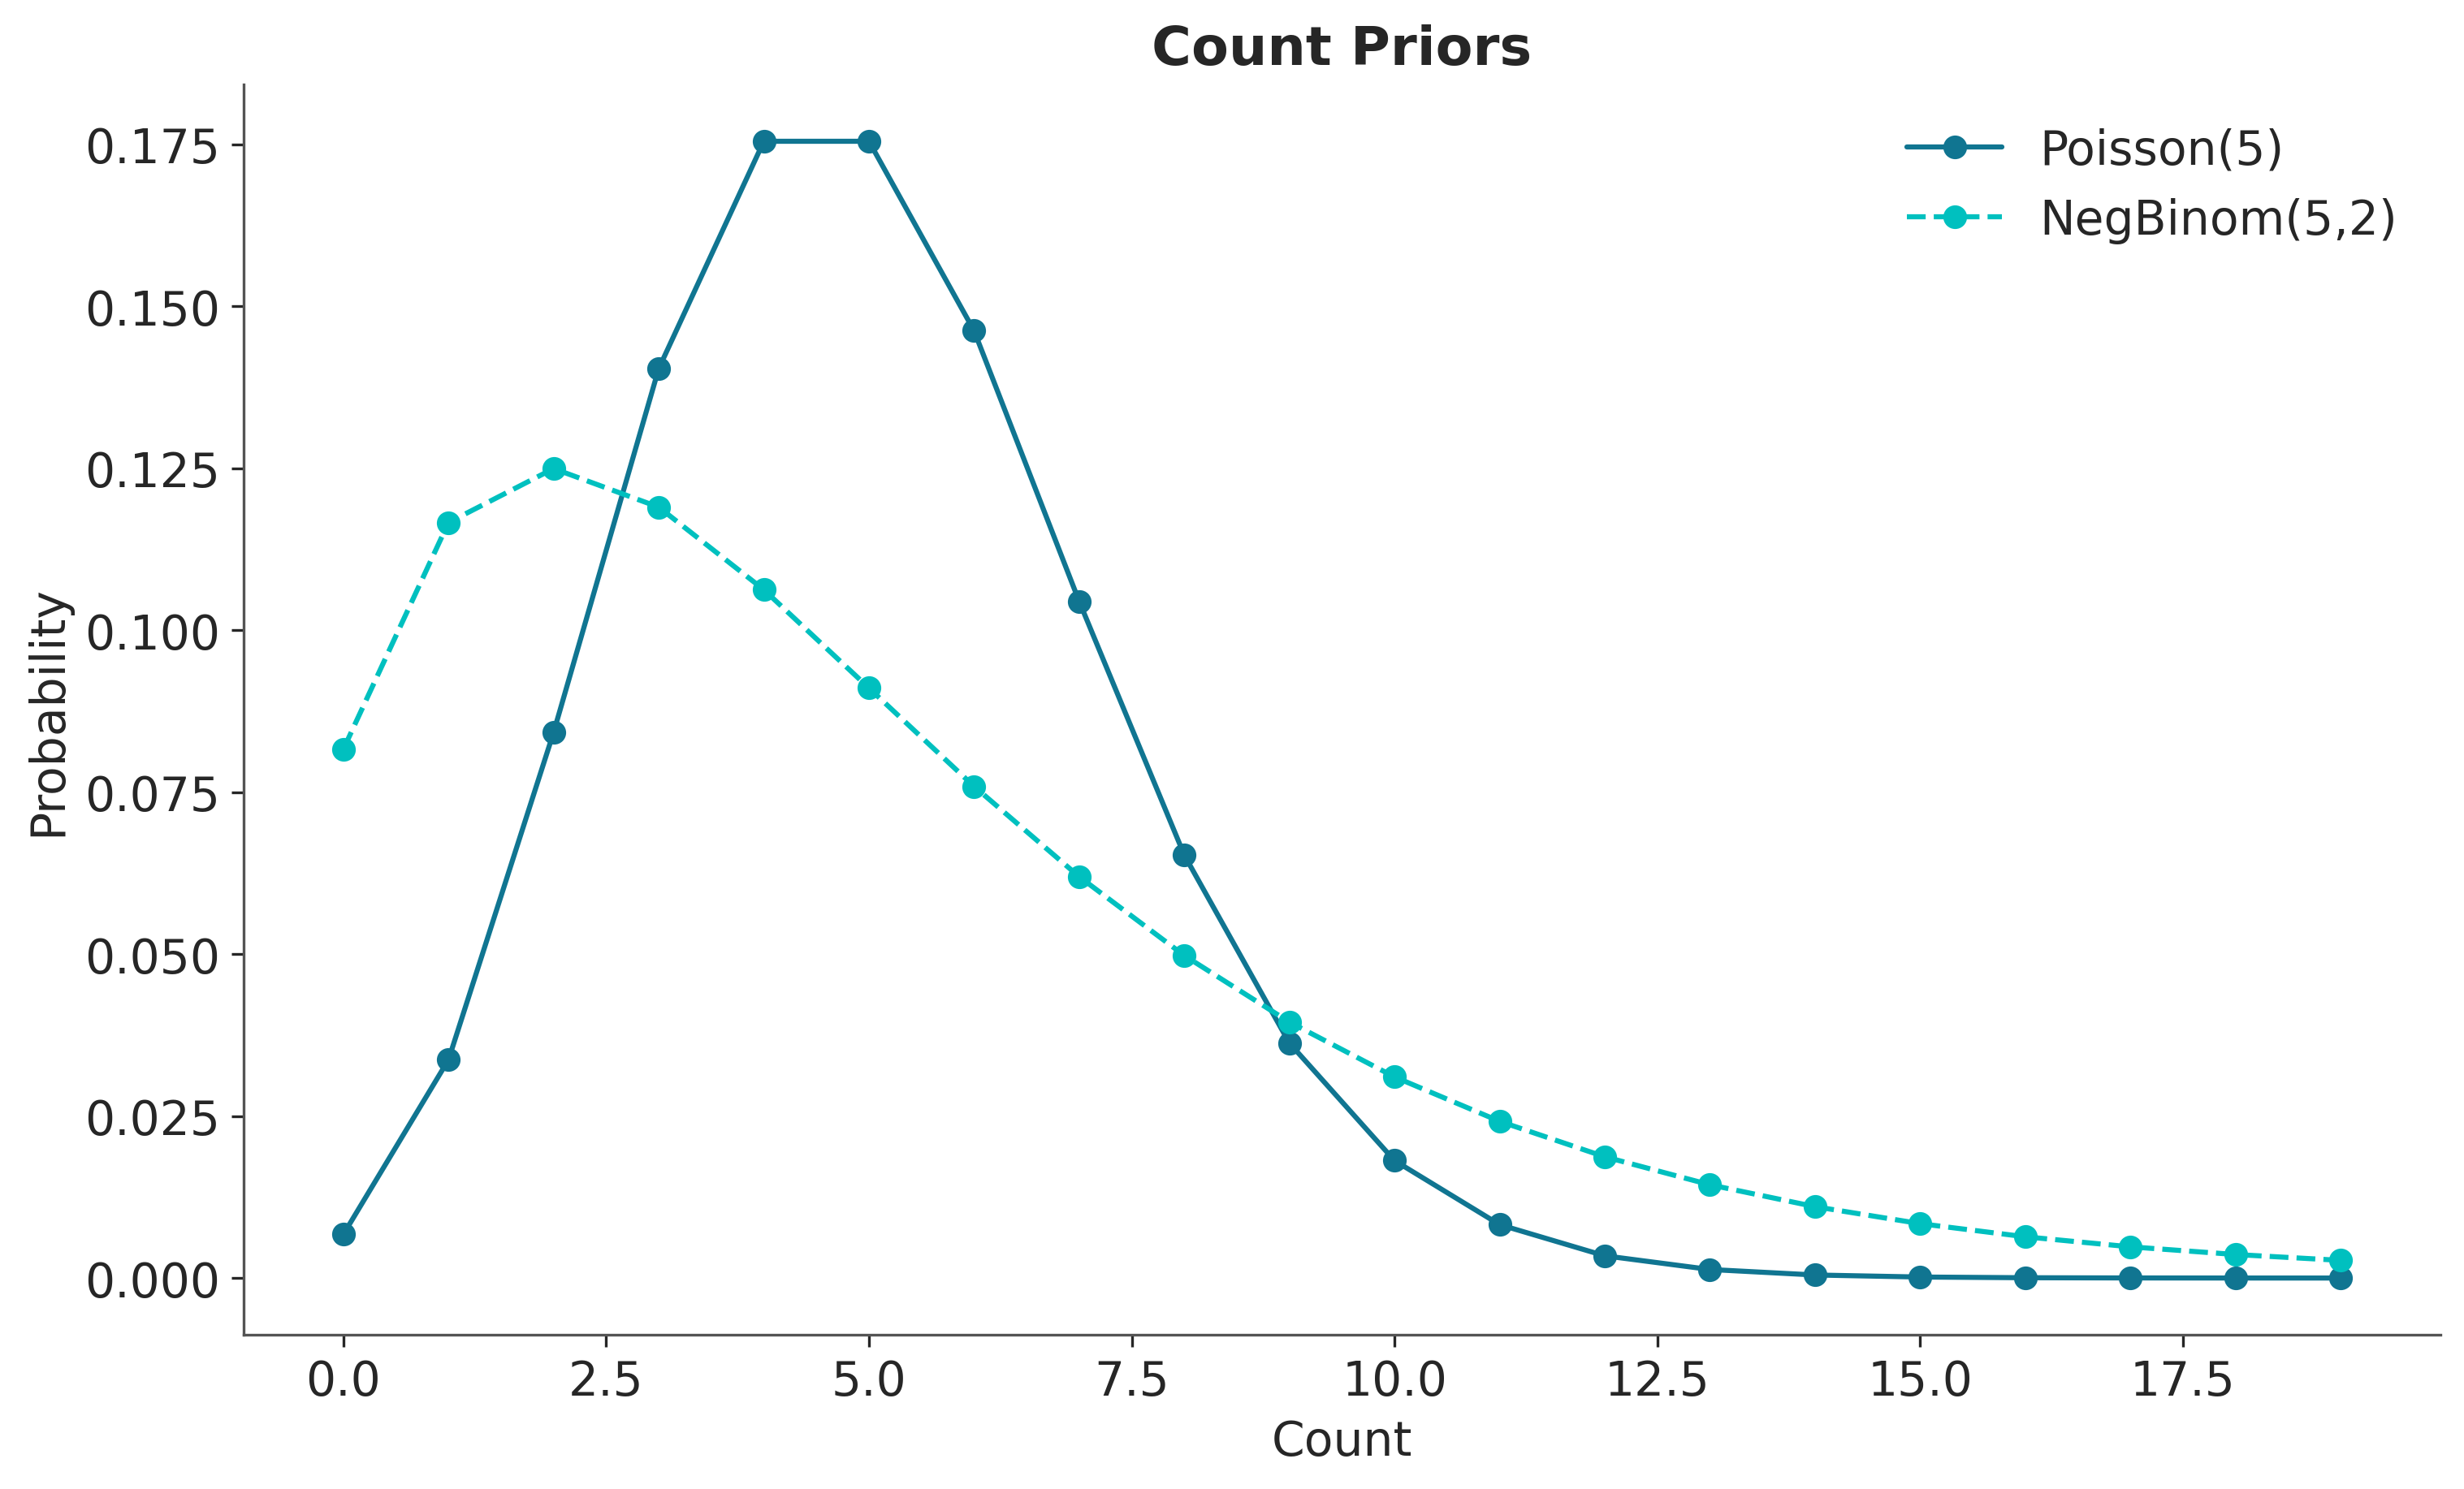

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x_count = np.arange(0, 20)
poisson_logpmf = pm.logp(pm.Poisson.dist(mu=5), x_count).eval()
nbinom_logpmf = pm.logp(pm.NegativeBinomial.dist(mu=5, alpha=2), x_count).eval()
pmf_poisson = np.exp(poisson_logpmf)
pmf_nbinom = np.exp(nbinom_logpmf)

ax.plot(x_count, pmf_poisson, marker='o', label='Poisson(5)')
ax.plot(x_count, pmf_nbinom, marker='o', linestyle='--', label='NegBinom(5,2)')
ax.set_title('Count Priors')
ax.set_xlabel('Count')
ax.set_ylabel('Probability')
ax.legend();

### Common Likelihood Functions

**For continuous data:**
- `Normal(mu, sigma)`: Symmetric errors around a mean
- `StudentT(nu, mu, sigma)`: Heavy-tailed errors, robust to outliers
- `Lognormal(mu, sigma)`: Positive data with right skew
- `Gamma(alpha, beta)`: Positive continuous data
- `Beta(alpha, beta)`: Data bounded between 0 and 1

**For discrete data:**
- `Bernoulli(p)`: Binary outcomes (0/1)
- `Binomial(n, p)`: Number of successes in n trials
- `Poisson(mu)`: Count data
- `NegativeBinomial(mu, alpha)`: Overdispersed counts
- `Categorical(p)`: One of K categories
- `Multinomial(n, p)`: Counts in K categories

## Part 4: Markov Chain Monte Carlo Methods

Now that we understand how to specify models in PyMC, we need to address a fundamental question: how do we actually fit these models? For all but the simplest cases, the posterior distribution cannot be derived analytically. This is where Markov Chain Monte Carlo (MCMC) methods become essential.

To understand how MCMC works in practice, let's explore the fundamental concepts through concrete examples. We'll start with basic Monte Carlo integration and build up to understanding why sophisticated algorithms like those in PyMC are necessary.

### The Challenge of Bayesian Computation

Recall Bayes' theorem:

$$P(\theta|x) = \frac{P(x|\theta) P(\theta)}{P(x)}$$

The denominator, $P(x) = \int P(x|\theta) P(\theta) \, d\theta$, is called the marginal likelihood or evidence. For most models, this integral is intractable:

1. **High dimensionality**: With multiple parameters, we need to integrate over many dimensions
2. **Complex dependencies**: Parameters often have intricate relationships
3. **Non-standard distributions**: The posterior rarely has a recognizable form

### Monte Carlo Integration

The foundation of all Monte Carlo methods is a simple but powerful idea: we can approximate integrals using random samples. Consider estimating the expected value of a function $h(\theta)$ under a probability distribution $p(\theta)$:

$$E[h(\theta)] = \int h(\theta) p(\theta) d\theta$$

If we can draw samples $\theta_1, \theta_2, ..., \theta_n$ from $p(\theta)$, then by the Law of Large Numbers:

$$E[h(\theta)] \approx \frac{1}{n} \sum_{i=1}^n h(\theta_i)$$

This approximation becomes exact as $n \to \infty$, and we can quantify the uncertainty in our estimate using the Central Limit Theorem.

The key challenge is: **how do we draw samples from a distribution when we only know it up to a normalizing constant?**

While Monte Carlo integration is powerful, it assumes we can directly sample from the distribution of interest. Markov Chain Monte Carlo (MCMC) methods provide an elegant solution to this problem.

### The Markov Chain Monte Carlo Solution

MCMC methods construct a Markov chain whose stationary distribution is the posterior distribution we want to sample from. The "Markov" property means that each sample depends only on the previous sample, not the entire history. The "Monte Carlo" aspect refers to the use of random sampling.

> A Markov chain is a sequence of random variables $\theta_1, \theta_2, ..., \theta_n$ that satisfy the Markov property:
>
> $$P(\theta_t | \theta_1, \theta_2, ..., \theta_{t-1}) = P(\theta_t | \theta_{t-1})$$
> 
> This means that the probability of the next state depends only on the current state, not the entire history.

The general MCMC algorithm follows this pattern:

1. Start at some initial parameter values $\theta^{(0)}$
2. For iteration $t = 1, 2, ...$:
   - Propose new parameter values $\theta^*$ based on current values $\theta^{(t-1)}$
   - Accept or reject the proposal based on the posterior probability
   - Set $\theta^{(t)} = \theta^*$ if accepted, otherwise $\theta^{(t)} = \theta^{(t-1)}$

Different MCMC algorithms vary in how they propose new values and decide whether to accept them. The art lies in designing proposals that efficiently explore the posterior distribution.


#### The Metropolis-Hastings Algorithm

The Metropolis-Hastings algorithm generates a Markov chain whose stationary distribution is the target posterior distribution. The key insight is the **Metropolis acceptance criterion**, which ensures detailed balance:

$$A(\theta^* | \theta) = \min\left\{1, \frac{\tilde{p}(\theta^*)}{\tilde{p}(\theta)} \cdot \frac{q(\theta|\theta^*)}{q(\theta^*|\theta)}\right\}$$

where:
- $\tilde{p}(\theta)$ is the unnormalized posterior
- $q(\theta^*|\theta)$ is the proposal distribution
- $A(\theta^* | \theta)$ is the acceptance probability

This criterion automatically adjusts for asymmetric proposals and ensures the chain converges to the correct distribution.

Let's implement the general Metropolis-Hastings algorithm:

In [ ]:
def metropolis_hastings(pdf, prop_dist, init=0):
    """General Metropolis-Hastings sampler.
    
    Args:
        pdf: Target probability density function (unnormalized is ok)
        prop_dist: Proposal distribution (scipy.stats distribution)
        init: Initial value
        
    Yields:
        (sample, accepted): Current sample and whether it was accepted
    """
    current = init
    while True:
        
        # Propose new state from proposal distribution
        prop = prop_dist.rvs()
        
        # Calculate acceptance ratio
        p_accept = min(1, pdf(prop) / pdf(current) * 
                      prop_dist.pdf(current) / prop_dist.pdf(prop))
        
        # Accept or reject
        accept = np.random.rand() < p_accept
        if accept:
            current = prop
        yield current, accept
        
def gen_samples(draws, sampler):
    """Generate samples from a sampler."""
    samples = np.empty(draws)
    accepts = 0
    for idx, (z, accept) in itertools.takewhile(lambda j: j[0] < draws, enumerate(sampler)):
        accepts += accept
        samples[idx] = z
    return samples, accepts

# Example: Sample from a mixture of Gaussians
def target_pdf(x):
    """Mixture of two Gaussians"""
    return 0.3 * st.norm.pdf(x, -2, 0.8) + 0.7 * st.norm.pdf(x, 3, 1.2)

# Use a wide normal as proposal
proposal_dist = st.norm(0, 10)

# Generate samples
samples, accepts = gen_samples(10_000, metropolis_hastings(target_pdf, proposal_dist))

# Visualize results
t = np.linspace(-6, 8, 500)
pdf_values = [target_pdf(x) for x in t]

hist = go.Histogram(
    x=samples,
    histnorm='probability density',
    name='Samples',
    marker=dict(color='rgba(0, 0, 255, 0.7)')
)

pdf_curve = go.Scatter(
    x=t, y=pdf_values,
    mode='lines',
    name='True PDF',
    line=dict(color='orange', width=2)
)

go.Figure(
    data=[hist, pdf_curve]
).update_layout(
    title=f'Metropolis-Hastings: {samples.size:,d} samples with {100 * accepts / samples.size:.1f}% acceptance rate',
    xaxis_title='Value',
    yaxis_title='Density',
    width=750,
    height=400
)

### Random Walk Metropolis-Hastings

The general Metropolis-Hastings algorithm can be inefficient if the proposal distribution is poorly chosen. A popular special case is **Random Walk Metropolis**, where the proposal is centered at the current position:

$$\theta^* \sim \mathcal{N}(\theta, \sigma^2)$$

This symmetric proposal simplifies the acceptance ratio because the proposal terms cancel out:

$$A(\theta^* | \theta) = \min\left\{1, \frac{\tilde{p}(\theta^*)}{\tilde{p}(\theta)}\right\}$$

The key hyperparameter is the step size $\sigma$:
- **Too small**: Chain takes tiny steps and explores slowly (high acceptance, slow mixing)
- **Too large**: Many proposals are rejected (low acceptance, slow mixing)
- **Just right**: Balance between acceptance rate and step size (typically 20-50% acceptance)

Let's implement and compare different step sizes:

In [12]:
def random_walk_metropolis(pdf, step_size, init=0):
    """Random walk Metropolis algorithm.
    
    Args:
        pdf: Target probability density function (unnormalized is ok)
        step_size: Standard deviation of proposal distribution
        init: Initial value
        
    Yields:
        (sample, accepted): Current sample and whether it was accepted
    """
    current = init
    while True:
        # Random walk proposal
        prop = current + np.random.normal(0, step_size)
        
        # Simple acceptance ratio (proposal terms cancel)
        p_accept = min(1, pdf(prop) / pdf(current))
        
        # Accept or reject
        accept = np.random.rand() < p_accept
        if accept:
            current = prop
        yield current, accept

# Compare different step sizes
fig = make_subplots(rows=3, cols=1, 
                    subplot_titles=['Small Step Size (σ=0.1)', 
                                   'Medium Step Size (σ=8.0)', 
                                   'Large Step Size (σ=70.0)'])

step_sizes = [0.1, 8.0, 70.0]

for i, step_size in enumerate(step_sizes, 1):
    # Generate samples
    samples, accepts = gen_samples(10_000, random_walk_metropolis(target_pdf, step_size))
    
    # Calculate t and pdf values for the line
    t = np.linspace(samples.min(), samples.max(), 500)
    pdf_values = [target_pdf(x) for x in t]
    
    # Add histogram
    fig.add_trace(
        go.Histogram(
            x=samples,
            histnorm='probability density',
            marker=dict(color='rgba(0, 0, 255, 0.7)'),
            name=f"Samples (σ={step_size})",
            showlegend=False
        ),
        row=i, col=1
    )
    
    # Add PDF line
    fig.add_trace(
        go.Scatter(
            x=t,
            y=pdf_values,
            mode='lines',
            line=dict(color='orange', width=2),
            name=f"True PDF",
            showlegend=False
        ),
        row=i, col=1
    )
    
    # Add annotation with acceptance rate
    fig.add_annotation(
        text=f"Acceptance rate: {100 * accepts / samples.size:.1f}%",
        xref=f"x{i}", yref=f"y{i}",
        x=0.95, y=0.95,
        xanchor="right", yanchor="top",
        showarrow=False,
        bgcolor="white",
        bordercolor="black",
        borderwidth=1
    )

fig.update_layout(height=900, width=700, showlegend=False)
fig.update_xaxes(title_text="Value", row=3, col=1)
fig.update_yaxes(title_text="Density")
fig.show()

### Visualizing MCMC Behavior

To better understand how different step sizes affect the sampler's behavior, let's look at trace plots that show the evolution of the chain over time:

In [13]:
# Generate shorter chains for visualization
n_steps = 1000

fig = make_subplots(rows=3, cols=1, 
                    subplot_titles=['Small Step Size (σ=0.1): Slow Exploration', 
                                   'Medium Step Size (σ=8.0): Good Mixing', 
                                   'Large Step Size (σ=70.0): Many Rejections'])

for i, step_size in enumerate(step_sizes, 1):
    # Generate samples
    sampler = random_walk_metropolis(target_pdf, step_size)
    trace = []
    for _ in range(n_steps):
        sample, _ = next(sampler)
        trace.append(sample)
    
    # Add trace plot
    fig.add_trace(
        go.Scatter(
            y=trace,
            mode='lines',
            line=dict(width=1),
            name=f"σ={step_size}",
            showlegend=False
        ),
        row=i, col=1
    )
    
    # Add horizontal lines at the modes
    fig.add_hline(y=-2, line_dash="dash", line_color="red", 
                  row=i, col=1, annotation_text="Mode 1")
    fig.add_hline(y=3, line_dash="dash", line_color="red", 
                  row=i, col=1, annotation_text="Mode 2")

fig.update_layout(height=900, width=800, showlegend=False)
fig.update_xaxes(title_text="Iteration", row=3, col=1)
fig.update_yaxes(title_text="Value")
fig.show()

### Modern MCMC: The No-U-Turn Sampler (NUTS)

While Metropolis-Hastings and its variants are foundational, they can be inefficient for complex, high-dimensional models. Modern MCMC algorithms like Hamiltonian Monte Carlo (HMC) and its extension, the No-U-Turn Sampler (NUTS), use gradient information to make more intelligent proposals.

#### Key Advantages of NUTS:

1. **Automatic tuning**: NUTS adapts its parameters during warmup, eliminating the need for manual tuning
2. **Efficient exploration**: Uses gradient information to propose distant points that are still likely to be accepted
3. **Handles correlations**: Can efficiently sample from highly correlated posteriors
4. **Fewer tuning parameters**: Works well "out of the box" for many models

#### When NUTS Shines:

- High-dimensional parameter spaces (dozens to thousands of parameters)
- Complex posterior geometries with strong correlations
- Models with continuous parameters

#### Implementation in PyMC:

PyMC uses NUTS as the default sampler for continuous variables. When you call `pm.sample()`, PyMC:

1. Automatically differentiates your model to compute gradients
2. Runs adaptation to tune the step size and mass matrix
3. Generates samples using the tuned sampler
4. Provides diagnostics to assess convergence

The beauty of PyMC is that all this complexity is hidden behind a simple interface. However, understanding the basics helps us interpret diagnostics and troubleshoot when things go wrong.

## Part 6: Real-Data Example — Dugongs Growth with PyMC

Let's conclude with a complete, real-data example that demonstrates the full PyMC workflow and API: modeling the growth of dugongs (sea cows).

### The Dugongs Growth Problem

We have measurements of dugong length at various ages. Marine biologists often model growth as an asymptotic curve: length increases rapidly early in life and gradually approaches a maximum adult size.

We'll build a Bayesian nonlinear regression model that:
1. Uses a biologically motivated growth curve
2. Quantifies uncertainty in parameters and predictions
3. Demonstrates core PyMC API features: model contexts, data containers, priors, deterministic transforms, sampling, diagnostics, and posterior predictive checks

In [14]:
# Load the dugongs dataset
# The first line of the CSV is a comment; skip it
dugongs = pl.read_csv("../data/dugongs.csv")

print(f"Dataset shape: {dugongs.shape}")
print(f"\nColumns: {dugongs.columns}")

# Display first few rows
dugongs.head()

Dataset shape: (27, 2)

Columns: ['age', 'length']


age,length
f64,f64
1.0,1.8
1.5,1.85
1.5,1.87
1.5,1.77
2.5,2.02


In [15]:
# Exploratory plot: length vs age
fig = px.scatter(
    dugongs, x="age", y="length",
    title="Dugongs: Length vs Age",
    labels={"age": "Age (years)", "length": "Length (m)"}
)
fig.update_traces(marker=dict(size=6, opacity=0.8))

### Modeling Approach

We model dugong length as an asymptotic growth curve (Carlin & Gelfand, 1991):

- Deterministic mean function: mu(age) = alpha - beta * gamma^age
  - alpha: adult asymptotic length (m)
  - beta: positive offset determining juvenile shortfall from alpha
  - gamma: rate parameter in (0, 1); smaller values approach alpha faster
- Likelihood: length_i ~ Normal(mu(age_i), sigma)

This parameterization showcases PyMC's strengths:
- Constrained priors (e.g., gamma in (0,1) via Beta prior)
- Deterministic transformations
- Data containers for covariates
- Posterior sampling with NUTS and predictive checks

In [16]:
# Prepare arrays for modeling
X = dugongs['age'].to_numpy()
y = dugongs['length'].to_numpy()

print(f"n = {X.size}, age range: {X.min()}–{X.max()} years")
print(f"length range: {y.min():.2f}–{y.max():.2f} m")

n = 27, age range: 1.0–31.5 years
length range: 1.77–2.72 m


### Building the Bayesian Nonlinear Growth Model

We use the asymptotic model:

$$\mu(\text{age}) = \alpha - \beta\,\gamma^{\text{age}},\quad 0<\gamma<1$$

- $\alpha$ (m): asymptotic adult length
- $\beta$ (m): positive offset controlling juvenile shortfall from $\alpha$
- $\gamma$ (unitless): growth rate (closer to 0 means faster approach to $\alpha$)
- $\sigma$ (m): observation noise

We place weakly-informative, biologically sensible priors and use a data container for ages so we can later generate predictions at new ages.

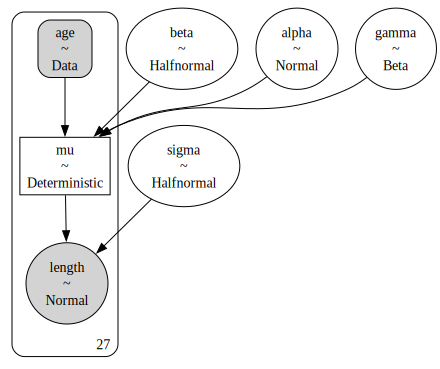

In [17]:
# Build the nonlinear growth model
with pm.Model() as dugong_model:
    
    # Data container for covariate
    age = pm.Data('age', X)
    
    # Priors
    alpha = pm.Normal('alpha', mu=y.max() + 0.2, sigma=0.5)   # asymptotic length (m)
    beta = pm.HalfNormal('beta', sigma=1.0)                        # positive offset (m)
    gamma = pm.Beta('gamma', alpha=2, beta=2)                      # growth rate in (0,1)
    sigma = pm.HalfNormal('sigma', sigma=0.2)                      # observation noise (m)
    
    # Mean function
    mu = pm.Deterministic('mu', alpha - beta * gamma**age)
    
    # Likelihood
    pm.Normal('length', mu=mu, sigma=sigma, observed=y)

# Visualize the model
pm.model_to_graphviz(dugong_model)

### Prior Predictive Checks

Before fitting the model, let's check that our priors generate reasonable predictions of dugong lengths across ages.

In [18]:
# Sample from prior predictive distribution
with dugong_model:
    prior_pred = pm.sample_prior_predictive(samples=1000, random_seed=RNG)

# Plot prior predictive distribution overlaid on data
prior_lengths = prior_pred.prior_predictive['length'].values.flatten()

fig = go.Figure()
fig.add_trace(go.Histogram(x=prior_lengths, name='Prior Predicted Length',
                          nbinsx=40, histnorm='probability', opacity=0.6))
fig.add_trace(go.Histogram(x=y, name='Observed Length',
                          nbinsx=30, histnorm='probability', opacity=0.6))
fig.update_layout(title='Prior Predictive Check: Dugong Lengths',
                 xaxis_title='Length (m)', yaxis_title='Probability', barmode='overlay')
fig.show()

print(f"Prior length 5–95%: {np.percentile(prior_lengths, 5):.2f}–{np.percentile(prior_lengths, 95):.2f} m")
print(f"Observed length min–max: {y.min():.2f}–{y.max():.2f} m")

Sampling: [alpha, beta, gamma, length, sigma]


Prior length 5–95%: 1.91–3.76 m
Observed length min–max: 1.77–2.72 m


### Fitting the Model

With reasonable priors confirmed, we now fit the dugongs growth model using NUTS.

In [19]:
# Fit the model
with dugong_model:
    trace = pm.sample(2000, tune=2000, random_seed=RNG)
    # Posterior predictive for model checking
    post_pred = pm.sample_posterior_predictive(trace, random_seed=RNG)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.
Sampling: [length]


Output()

### Analyzing Results

Now we examine the posterior distributions to understand the inferred growth parameters and uncertainty.

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  2.642  0.068   2.524    2.770      0.001    0.001    2996.0    2765.0   
beta   0.970  0.077   0.821    1.111      0.001    0.001    4586.0    3927.0   
gamma  0.858  0.033   0.799    0.916      0.001    0.001    3079.0    3137.0   
sigma  0.100  0.015   0.073    0.127      0.000    0.000    3847.0    3087.0   

       r_hat  
alpha    1.0  
beta     1.0  
gamma    1.0  
sigma    1.0  


array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'gamma'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

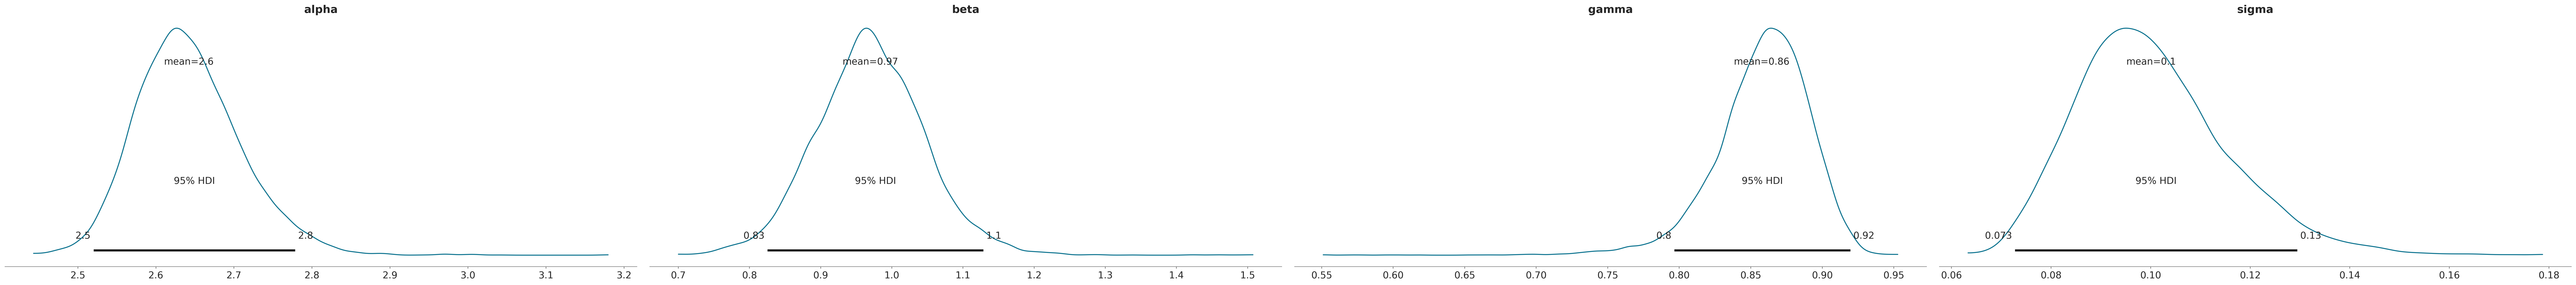

In [20]:
# Summary statistics for growth parameters
print(az.summary(trace, var_names=['alpha', 'beta', 'gamma', 'sigma']))

# Visualize posterior for parameters
az.plot_posterior(trace, var_names=['alpha', 'beta', 'gamma', 'sigma'], hdi_prob=0.95)

### Model Checking

We check whether the model captures the observed length–age relationship using posterior predictive checks and by overlaying fitted curves.

Sampling: []


Output()

/tmp/ipykernel_292861/2565667497.py:20: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/tmp/ipykernel_292861/2565667497.py:30: UserWarning:

The figure layout has changed to tight



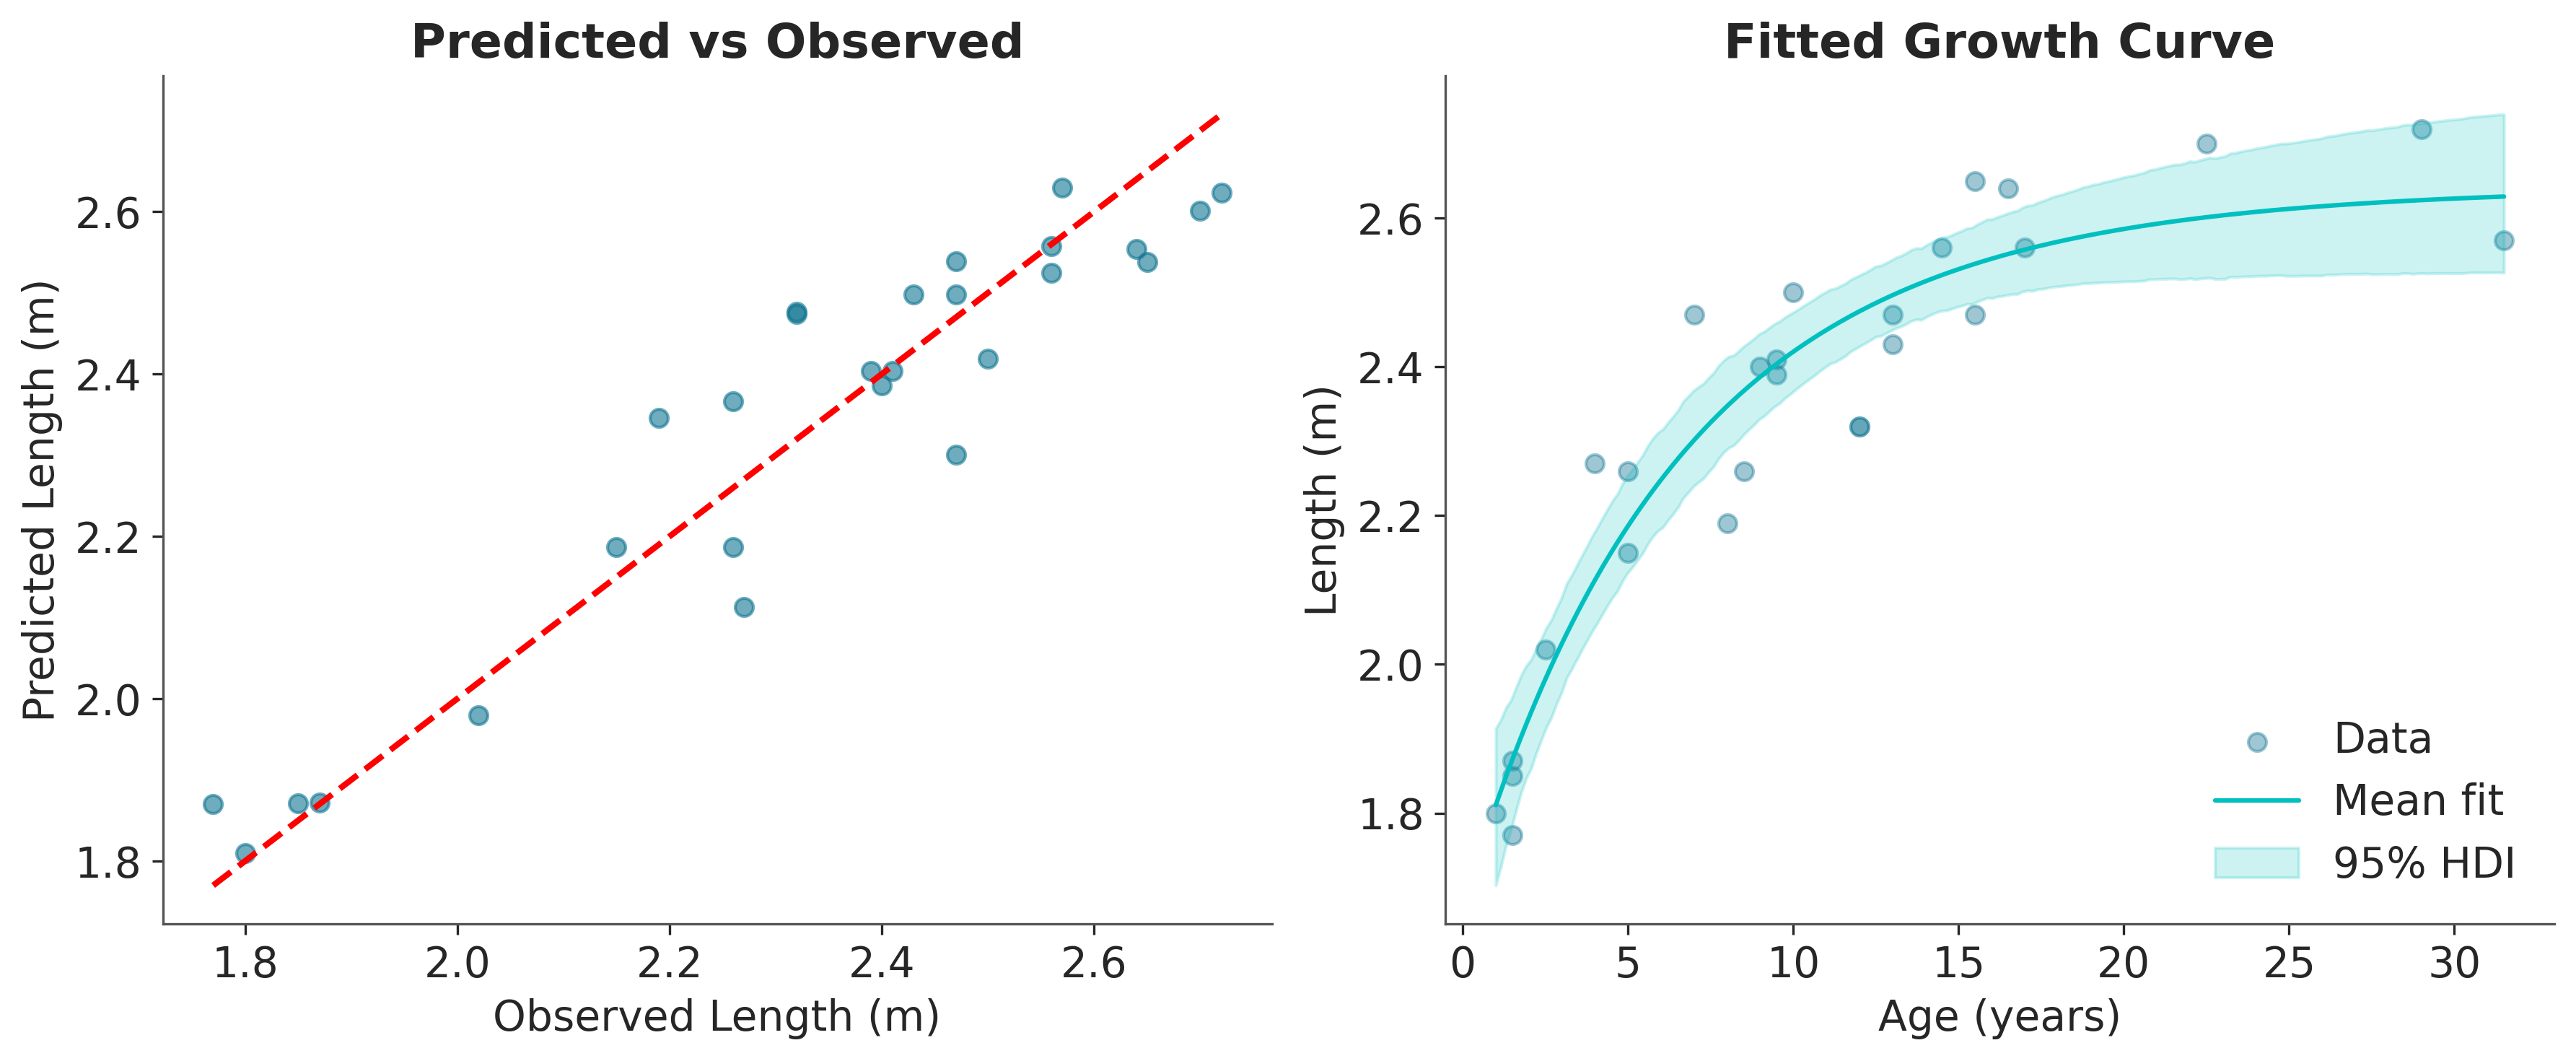

Bayesian R² (pointwise mean predictions): 0.889


In [21]:
# Posterior predictive checks and fitted curve overlay
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Predicted vs Actual length
y_pred = post_pred.posterior_predictive['length'].mean(dim=['chain', 'draw']).values
axes[0].scatter(y, y_pred, alpha=0.6)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0].set_xlabel('Observed Length (m)')
axes[0].set_ylabel('Predicted Length (m)')
axes[0].set_title('Predicted vs Observed')

# Plot 2: Overlay fitted mean curve and 95% credible band
ages_grid = np.linspace(X.min(), X.max(), 200)
with dugong_model:
    pm.set_data({'age': ages_grid})
    post_curve = pm.sample_posterior_predictive(trace, var_names=['mu'], random_seed=RNG)

mu_samples = post_curve.posterior_predictive['mu'].values  # shape: (chains, draws, 200)
mu_mean = mu_samples.mean(axis=(0,1))
mu_hdi = az.hdi(mu_samples.reshape(-1, mu_samples.shape[-1]), hdi_prob=0.95)

axes[1].scatter(X, y, alpha=0.4, label='Data')
axes[1].plot(ages_grid, mu_mean, color='C1', label='Mean fit')
axes[1].fill_between(ages_grid, mu_hdi[:,0], mu_hdi[:,1], color='C1', alpha=0.2, label='95% HDI')
axes[1].set_xlabel('Age (years)')
axes[1].set_ylabel('Length (m)')
axes[1].set_title('Fitted Growth Curve')
axes[1].legend()

plt.tight_layout()
plt.show()

# Compute simple R^2 on lengths
ess_res = np.sum((y - y_pred)**2)
ss_tot = np.sum((y - y.mean())**2)
r_squared = 1 - (ess_res / ss_tot)
print(f"Bayesian R² (pointwise mean predictions): {r_squared:.3f}")

### Making Predictions with Uncertainty

One of the key advantages of Bayesian modeling is full uncertainty quantification. Let's predict length at new ages with credible intervals.

In [ ]:
# Continuous predictions with uncertainty ribbon (Plotly)
ages_grid = np.linspace(X.min(), X.max(), 200)
with dugong_model:
    pm.set_data({'age': ages_grid})
    post_curve = pm.sample_posterior_predictive(trace, var_names=['mu'], random_seed=RNG)

# Mean function draws over the grid: (chains, draws, grid)
mu_grid = post_curve.posterior_predictive['mu'].values
# Flatten chains/draws to one draw axis
mu_flat = mu_grid.reshape(-1, mu_grid.shape[-1])  # (n_draws, grid)
sigma_draws = trace.posterior.sigma.values.reshape(-1)

noise = np.random.default_rng(RNG).normal(0.0, sigma_draws[:, None], size=mu_flat.shape)
y_grid_draws = mu_flat + noise

q_low, q_med, q_high = np.quantile(y_grid_draws, [0.025, 0.5, 0.975], axis=0)
y_mean = y_grid_draws.mean(axis=0)
go.Figure().add_trace(
    go.Scatter(x=ages_grid, y=q_low, line=dict(color='rgba(31,119,180,0)'), showlegend=False, hoverinfo='skip')
).add_trace(
    go.Scatter(x=ages_grid, y=q_high, fill='tonexty', fillcolor='rgba(31,119,180,0.25)', line=dict(color='rgba(31,119,180,0)'), name='95% predictive band', hoverinfo='skip')
).add_trace(
    go.Scatter(x=ages_grid, y=y_mean, name='Mean prediction', line=dict(color='rgb(31,119,180)', width=2))
).add_trace(
    go.Scatter(x=X, y=y, mode='markers', name='Observed', marker=dict(color='black', size=5, opacity=0.45), hovertemplate='Age=%{x}<br>Observed=%{y}<extra>Observed</extra>')
).update_layout(
    template='plotly_white',
    xaxis_title='Age (years)',
    yaxis_title='Length (m)',
    legend_title_text='',
    hovermode='x unified',
    title='Predictions with Uncertainty'
)


Sampling: []


Output()

## Summary and Key Takeaways

In this session, we've covered the essential components of building Bayesian models with PyMC:

### PyMC Fundamentals
- **Model Context**: All PyMC models exist within a context that tracks variable relationships
- **Distributions**: PyMC provides a rich library of probability distributions for priors and likelihoods
- **Random Variables**: Parameters and data are represented as random variables with associated distributions
- **Automatic Differentiation**: PyMC handles gradient calculations automatically

### MCMC Concepts
- **The Challenge**: Bayesian inference requires integration over high-dimensional spaces
- **The Solution**: MCMC methods draw samples from the posterior distribution
- **Metropolis-Hastings**: The foundational MCMC algorithm that inspired modern methods
- **Tuning Matters**: Step size and other hyperparameters critically affect performance
- **Modern Algorithms**: NUTS (used by PyMC) efficiently explores complex posteriors
- **Convergence**: Multiple chains help assess whether sampling has converged

### Practical Workflow
1. **Model Specification**: Encode assumptions using priors and likelihoods
2. **Prior Predictive Checks**: Verify that priors generate reasonable data
3. **Sampling**: Use `pm.sample()` to draw from the posterior
4. **Diagnostics**: Check convergence and sampling quality
5. **Posterior Analysis**: Examine parameter estimates and uncertainties
6. **Posterior Predictive Checks**: Verify that the model captures data patterns
7. **Predictions**: Generate predictions with full uncertainty quantification

### Key Advantages of Bayesian Modeling
- **Uncertainty Quantification**: Get distributions, not just point estimates
- **Prior Information**: Incorporate domain knowledge systematically
- **Hierarchical Models**: Naturally handle grouped data (next session!)
- **Model Comparison**: Principled ways to compare models
- **Missing Data**: Automatic handling of missing values

### Next Steps
In the next session, we'll extend these concepts to hierarchical models, which allow us to model data with natural grouping structures. We'll see how Bayesian methods excel at sharing information across groups while respecting their differences.

### Exercises
1. Try different prior distributions and observe their effect on the posterior
2. Fit separate models for different fish species and compare results
3. Add interaction terms between predictors
4. Implement a robust regression using Student-t likelihood instead of Normal
5. Use cross-validation to assess predictive performance

In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Sep 05 2025

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 9.5.0

numpy     : 2.2.6
arviz     : 0.22.0
polars    : 1.32.3
plotly    : 6.3.0
matplotlib: 3.10.6
scipy     : 1.16.1
platform  : 1.0.8
pymc      : 5.25.1

Watermark: 2.5.0

